# P02-03: Modularity Optimisation

*April 30 2020*  

In the third and last unit of this week's practice lecture, we explore the partition quality function $Q(n, C)$ that captures how well a given mapping of nodes to communities is aligned with the topology of a network. We use this function to develop a simple community detection algorithm that is based on the heuristic optimisation of partition quality. We also implement the community assortativity coefficient, which allows us to compare the optimal partition quality (i.e. modularity) to the maximally possible modularity in a given network.

In [1]:
import pathpy as pp
import numpy as np

import sqlite3
from tqdm import tqdm

import random
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")

[04-30 20:59:36: DEBUG] pathpy version 3.0.0a1
[04-30 20:59:36: DEBUG] platform is win32
[04-30 20:59:36: DEBUG] pathpy runs in a vs code environment


## Partition quality

We first implement the partition quality function as introduced in theory lecture L02. We assume that the community partition is given as a dictionary that assigns community labels to each node.

In [2]:
def Q(network, C):
    m = network.number_of_edges()
    n = network.number_of_nodes()

    A = network.adjacency_matrix().todense()

    q = 0.0
    for v in network.nodes.uids:
        for w in network.nodes.uids:
            if C[v] == C[w]:
                q += A[network.nodes.index[v], network.nodes.index[w]] - network.degrees()[v] * network.degrees()[w]/(2*m)
    q /= 2*m
    return q

We can now test our function in the example network from the lecture.

In [3]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('b', 'd')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')
n.plot()

[04-30 20:59:37: DEBUG] Draw d3js object as html file
[04-30 20:59:37: DEBUG] Generate single html document.


We compute the partition quality for two different partitions: The first partition is contrary to the actual community pattern in the network, which results in a negative value for the partition quality:

In [4]:
C_bad = {'a': 1, 'b': 2, 'c': 3, 'd': 1, 'e': 2, 'f': 3, 'g': 4}

q = Q(n, C_bad)
print(q)

-0.27777777777777773


The second partition is better aligned with the community structure, but still smaller than the value that we would obtain for an optimal partition:

In [5]:
C_better = {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 2, 'f': 2, 'g': 2}

q = Q(n, C_better)
print(q)

0.14197530864197536


### Modularity Optimisation

To determine the modularity, i.e. the partition quality of the best partition) of the network we implement a heuristic optimisation algorithm that finds the optimal modularity $Q_{opt}$ across all partitions. The algorithm is naive and inefficient, but easy to understand. It works as follows:

1) We start with a partition where we place each node in a separate community  
2) We draw two communities uniformly at random and merge them to a single community iff this merge increases partition quality   
3) We repeat the second step for a given number of iterations and output the final partition and partition quality  

To implement this (more or less) efficiently, we implement a function `Q_merge` that computes the modularity of the network under the assumption that a set of communities are merged to a single community. This allows us to test the partition quality of merged communities without actually merging them.

In [6]:
def Q_merge(network, A, D, n, m, C, merge=set()):
    q = 0.0
    for v in network.nodes.uids:
        for w in network.nodes.uids:
            if C[v] == C[w] or (C[v] in merge and C[w] in merge):
                q += A[network.nodes.index[v], network.nodes.index[w]] - D[v]*D[w]/(2*m)
    q /= 2*m
    return q

def find_communities(network, iterations=100):
    # start with each node being in a separate cluster

    A = network.adjacency_matrix(weighted=False)
    D = network.degrees()
    n = network.number_of_nodes()
    m = network.number_of_edges()

    C = {}
    nums = np.zeros(iterations)
    num_communities = n
    community_to_nodes = {}
    c = 0
    for v in network.nodes.uids:
        C[v] = c
        community_to_nodes[c] = set([v])
        c += 1
    q = Q_merge(network, A, D, n, m, C)
    
    for i in tqdm(range(iterations), desc='maximising modularity'):

        nums[i] = num_communities

        # randomly choose two communities
        x, y = random.sample(community_to_nodes.keys(), 2)

        # check Q of merged communities
        q_new = Q_merge(network, A, D, n, m, C, merge=set([x, y]))

        if q_new > q:
            # merge communities
            for v in community_to_nodes[x]:
                C[v] = y
            community_to_nodes[y] = community_to_nodes[y].union(community_to_nodes[x])
            q = q_new
            num_communities -=1
            del community_to_nodes[x]
        
    return C, q, nums

To conveniently visualise communities, we implement the following method, which generates a community-based mapping of nodes to colors, which can then be passed to the `plot` function of `pathpy`. The function supports a maximum of 20 different communities and it will wrap around colors if this number is exceeded.

In [7]:
def map_colors(n, communities):
    colors = ['red', 'green', 'blue', 'orange', 'yellow', 'cyan', 'blueviolet', \
              'chocolate', 'magenta', 'navy', 'plum', 'thistle', 'wheat', 'turquoise', \
              'steelblue', 'grey', 'powderblue', 'orchid', 'mintcream', 'maroon']
    node_colors = {}
    community_color_map = {}
    i = 0
    for v in n.nodes.uids:
        if communities[v] not in community_color_map:
            community_color_map[communities[v]] = i%len(colors)
            i += 1
        node_colors[v] = colors[community_color_map[communities[v]]]
    return node_colors

We use the heuristic optimisation method to calculate $Q_{opt}$ for the toy example and plot the detected communities by coloring the nodes appropriately. We assign colors to nodes using the `node_color` parameter of the `plot` function.

In [8]:
C, q_opt, nums = find_communities(n)
print(C)
print('Modularity =', q_opt)
n.plot(node_color=map_colors(n, C))

maximising modularity: 100%|██████████| 100/100 [00:00<00:00, 1122.57it/s]
[04-30 20:59:38: DEBUG] Draw d3js object as html file
[04-30 20:59:38: DEBUG] Generate single html document.
{'e': 0, 'b': 0, 'd': 0, 'a': 3, 'g': 0, 'f': 0, 'c': 3}
Modularity = 0.1234567901234568


## Community assortativity coefficient

In the example above, we find that the modularity of the network is well below the theoretical maximum of one. Nevertheless, there is a clearly visible and strong community structure consisting of two clusters of nodes that are connected by a single link. Using the definition from theory lecture L02 we can implement a function that computes the theoretical maximum modularity $Q_{max}$ for a given network and partition:

In [9]:
def Qmax(network, C):
    m = network.number_of_edges()
    qmax = 2*m
    for v in network.nodes.uids:
        for w in network.nodes.uids:
            if C[v] == C[w]:
                qmax -= network.degrees()[v]*network.degrees()[w]/(2*m)
    
    return qmax/(2*m)

We use this to calculate the maximum possible partition quality for the toy example and as well as the *community assortativity coefficient* defined in theory lecture L02:

In [10]:
C, q_opt, nums = find_communities(n)
print('Q_opt =', q_opt)

q_max = Qmax(n, C)
print('Q_max =', q_max)

print("Community assortativity coefficient =", q_opt/q_max)

maximising modularity: 100%|██████████| 100/100 [00:00<00:00, 1161.77it/s]Q_opt = 0.3641975308641976
Q_max = 0.4753086419753089
Community assortativity coefficient = 0.7662337662337659



## Modularity-based community detection in `pathpy`

The simple modularity maximisation algorithm above is implemented in the `pathpy` function `modularity_maximisation`:

In [11]:
C, q = pp.algorithms.community_detection.modularity_maximisation(n, iterations=100)
print('Community partition =', C)
print('Modularity =', q)

maximising modularity: 100%|██████████| 100/100 [00:00<00:00, 666.01it/s]Community partition = {'e': 5, 'b': 3, 'd': 3, 'a': 3, 'g': 5, 'f': 5, 'c': 3}
Modularity = 0.14197530864197536



We can also use the function `color_map` to generate a color mapping that can be directly passed to the `plot` function:

In [12]:
n.plot(node_color=pp.algorithms.community_detection.color_map(n, C))

[04-30 20:59:39: DEBUG] Draw d3js object as html file
[04-30 20:59:39: DEBUG] Generate single html document.


## Modularity-based Community Detection in Empirical networks

We conclude this weeks practice lecture by an application of modularity-based community detection to empirical networks. We limit ourselves to the undirected networks `highschool`, `physician`, and `lotr` in our database:

In [13]:
n_highschool = pp.io.read_sql('networks.db', sql='SELECT source, target FROM "highschool"', directed=False)
n_physicians = pp.io.read_sql('networks.db', sql='SELECT source, target FROM "physicians"', directed=False)
n_lotr = pp.io.read_sql('networks.db', sql='SELECT source, target FROM "lotr"', directed=False)

[04-30 20:59:39: DEBUG] Load sql file as pandas data frame.
[04-30 20:59:39: INFO ] No column v, searching for synonyms
[04-30 20:59:39: INFO ] Remapping column 'source' to 'v'
[04-30 20:59:39: INFO ] No column w, searching for synonyms
[04-30 20:59:39: DEBUG] Creating False network
[04-30 20:59:39: INFO ] Remapping column 'target' to 'w'
[04-30 20:59:39: DEBUG] Load sql file as pandas data frame.
[04-30 20:59:39: INFO ] No column v, searching for synonyms
[04-30 20:59:39: INFO ] Remapping column 'source' to 'v'
[04-30 20:59:39: INFO ] No column w, searching for synonyms
[04-30 20:59:39: DEBUG] Creating False network
[04-30 20:59:39: INFO ] Remapping column 'target' to 'w'
[04-30 20:59:40: DEBUG] Load sql file as pandas data frame.
[04-30 20:59:40: INFO ] No column v, searching for synonyms
[04-30 20:59:40: INFO ] Remapping column 'source' to 'v'
[04-30 20:59:40: INFO ] No column w, searching for synonyms
[04-30 20:59:40: DEBUG] Creating False network
[04-30 20:59:40: INFO ] Remapping 

We use `matplotlib` to plot the number of detected communities against the number of iterations performed by the optimisation algorithm in our implementation of the method `find_communities`. This can help us determine that the algorithm has converged:

maximising modularity: 100%|██████████| 2000/2000 [00:57<00:00, 34.66it/s]
Number of communities = 5
Modularity = 0.654957857811783
Community assortativity coefficient = 0.9113054616930664


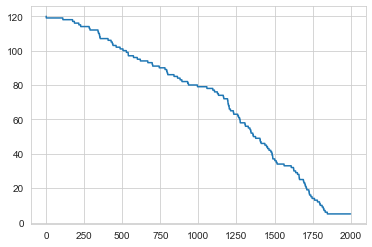

In [14]:
C, q_opt, nums = find_communities(n_highschool, iterations=2000)
q_max = Qmax(n_highschool, C)

print("Number of communities =", len(set(C.values())))
print("Modularity =", q_opt)
print("Community assortativity coefficient =", q_opt/q_max)
plt.clf()
plt.plot(nums)
plt.show()

We can now visualise the detected communities:

In [15]:
n_highschool.plot(node_color=map_colors(n_highschool, C))

[04-30 21:00:41: DEBUG] Draw d3js object as html file
[04-30 21:00:41: DEBUG] Generate single html document.


We finally repeat our analysis for the physicians and the lotr networks:

maximising modularity: 100%|██████████| 5000/5000 [14:23<00:00,  5.79it/s]
Number of communities = 4
Modularity = 0.6700392500356694
Community assortativity coefficient = 0.9999999999998895


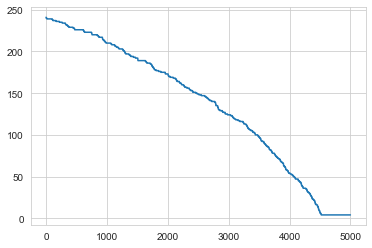

In [16]:
C, q_opt, nums = find_communities(n_physicians, iterations=5000)
q_max = Qmax(n_physicians, C)

print("Number of communities =", len(set(C.values())))
print("Modularity =", q_opt)
print("Community assortativity coefficient =", q_opt/q_max)
plt.clf()
plt.plot(nums)
plt.show()

In [17]:
n_physicians.plot(node_color=map_colors(n_physicians, C))

[04-30 21:15:11: DEBUG] Draw d3js object as html file
[04-30 21:15:11: DEBUG] Generate single html document.


maximising modularity: 100%|██████████| 5000/5000 [09:41<00:00,  8.60it/s]
Number of communities = 6
Modularity = 0.24785637464282353
Community assortativity coefficient = 0.370824630872077


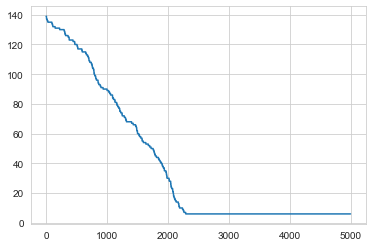

In [18]:
C, q_opt, nums = find_communities(n_lotr, iterations=3000)
q_max = Qmax(n_lotr, C)

print("Number of communities =", len(set(C.values())))
print("Modularity =", q_opt)
print("Community assortativity coefficient =", q_opt/q_max)
plt.clf()
plt.plot(nums)
plt.show()

In [20]:
n_lotr.plot(node_color=map_colors(n_lotr, C))

[04-30 21:27:36: DEBUG] Draw d3js object as html file
[04-30 21:27:36: DEBUG] Generate single html document.
